## Linh Nguyen - ID 170037344

# SMM750 - Final coursework

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay, accuracy_score, confusion_matrix, roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [65]:
# Load data
data_raw = pd.read_csv('./data/employee_attrition_previous_closure.csv')

In [66]:
def encode(X, encoder):
    X = pd.concat(
        [
            X.drop(encoder.feature_names_in_, axis=1),
            pd.DataFrame(
                encoder.transform(X[encoder.feature_names_in_]),
                columns=encoder.get_feature_names_out(),
                index=X.index,
            ),
        ],
        axis=1,
    )
    return X


def scale(X, scaler):
    return pd.DataFrame(
        scaler.transform(X),
        columns=X.columns,
        index=X.index
    )

def impute(X, imputer):
    return pd.DataFrame(
        imputer.transform(X),
        columns=X.columns,
        index=X.index
    )


def preprocess(X, encoder, scaler, imputer, to_drop_cols):
    X_processed = X.drop(to_drop_cols, axis=1)
    X_processed['Age'] = X_processed['Age'].fillna(X_processed['TotalWorkingYears'] + 18)
    X_processed = encode(X_processed, encoder)
    X_processed = scale(X_processed, scaler)
    X_processed = impute(X_processed, imputer)

    return X_processed


def binarise_y(y):
    return y.map({'Yes': 1, 'No': 0})


def grid_search(model, parameters, X_train, X_test, y_train, y_test):
    # Find the best combination of model parameters using cross validation
    clf = GridSearchCV(
        model,
        parameters,
        cv=3,
        scoring=['neg_log_loss', 'roc_auc', 'accuracy'],
        refit='roc_auc',
    )

    clf = clf.fit(X_train, y_train)

    print('best_params: ', clf.best_params_)

    # Evaluate the model's metrics
    print('--CROSS VALIDATION--')
    print('roc_auc:', np.round(clf.cv_results_['mean_test_roc_auc'][clf.best_index_], 3))
    print('accuracy:', np.round(clf.cv_results_['mean_test_accuracy'][clf.best_index_], 3))

    print('--TEST--')
    y_pred_test = clf.predict(X_test)
    y_pred_test_prob = clf.predict_proba(X_test)[:, 1]
    print('roc_auc:', np.round(roc_auc_score(y_test, y_pred_test_prob), 3))
    print('accuracy:', np.round(accuracy_score(y_test, y_pred_test), 3))

    return clf

In [67]:
# region preprocess data
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
to_drop_cols = ['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18', 'DistanceFromHome']

# Work on a copy
data = data_raw.copy()
data['Age'] = data['Age'].fillna(data['TotalWorkingYears'] + 18)

# Features and labels
X = data.drop('Attrition', axis=1)
y = data['Attrition']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_train[cat_cols])
X_train = encode(X_train, encoder)

# Drop redundant columns
X_train = X_train.drop(to_drop_cols, axis=1)

# Scale data
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scale(X_train, scaler)

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
imputer = imputer.fit(X_train)
X_train = impute(X_train, imputer)

y_train = binarise_y(y_train)

X_test = preprocess(X_test, encoder, scaler, imputer, to_drop_cols)
y_test = binarise_y(y_test)
# endregion

# Drop high VIF columns

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = preprocess(X.copy(), encoder, scaler, imputer, to_drop_cols)

# Checking VIF
def check_vif(X):
    vif = pd.Series(
        [
            variance_inflation_factor(X, i)
            for i in range(X.shape[1])
        ],
        index=X.columns,
    ).sort_values()

    print('All VIF < 5: ', all(vif < 5))

    return vif

check_vif(X_vif)


All VIF < 5:  False


RelationshipSatisfaction              1.031408
JobSatisfaction                       1.034034
MonthlyRate                           1.039051
HourlyRate                            1.039581
EnvironmentSatisfaction               1.043575
OverTime_Yes                          1.047195
WorkLifeBalance                       1.047206
JobInvolvement                        1.052176
DailyRate                             1.052416
Gender_Male                           1.054055
TrainingTimesLastYear                 1.056093
BusinessTravel_nan                    1.071030
MaritalStatus_nan                     1.072575
Education                             1.107728
NumCompaniesWorked                    1.300910
YearsSinceLastPromotion               1.662619
MaritalStatus_Married                 1.882114
StockOptionLevel                      1.889985
JobRole_Manufacturing Director        1.941480
Age                                   2.189732
BusinessTravel_Travel_Frequently      2.492929
BusinessTrave

In [69]:
high_vif_cols = ['Department_Research & Development', 'EducationField_Life Sciences', 'MonthlyIncome', 'Department_Sales', 'JobLevel']
check_vif(X_vif.drop(high_vif_cols, axis=1))

All VIF < 5:  True


HourlyRate                          1.028566
RelationshipSatisfaction            1.028960
JobSatisfaction                     1.031974
MonthlyRate                         1.035939
EnvironmentSatisfaction             1.041145
WorkLifeBalance                     1.042039
OverTime_Yes                        1.044373
JobInvolvement                      1.046038
DailyRate                           1.050786
Gender_Male                         1.050947
TrainingTimesLastYear               1.055209
MaritalStatus_nan                   1.058272
BusinessTravel_nan                  1.070013
Education                           1.103299
EducationField_Other                1.120687
EducationField_Technical Degree     1.122617
EducationField_Medical              1.227022
NumCompaniesWorked                  1.292815
JobRole_Human Resources             1.404068
EducationField_Marketing            1.502192
YearsSinceLastPromotion             1.642456
JobRole_Research Director           1.728806
MaritalSta

In [70]:
# Drop the high VIF columns from X_train
X_train = X_train.drop(high_vif_cols, axis=1)
X_test = X_test.drop(high_vif_cols, axis=1)

# Most important factors in predicting attrition

In [71]:
## Significance

import statsmodels.api as sm
model = sm.Logit(y_train, X_train).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.601750
         Iterations 5


In [72]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                  823
Model:                          Logit   Df Residuals:                      783
Method:                           MLE   Df Model:                           39
Date:                Fri, 16 Dec 2022   Pseudo R-squ.:                 -0.3139
Time:                        08:08:08   Log-Likelihood:                -495.24
converged:                       True   LL-Null:                       -376.92
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Age                                 -0.1142      0.115     -0.992      0.321      -0.340       0.111
DailyRate                           -0.0053      0.080     -0.067

In [73]:
logit_sum = model.conf_int()
logit_sum['pvalues'] = model.pvalues
logit_sum['coeff'] = model.params
logit_sum.rename(columns={0: '2.5th percentile', 1: '97.5th percentile'}, inplace=True)
significant_var = logit_sum.query('pvalues < 0.05').sort_values('coeff')
significant_var = significant_var.reset_index()
significant_var

,index,2.5th percentile,97.5th percentile,pvalues,coeff
0,YearsInCurrentRole,-0.532422,-0.019794,3.474443e-02,-0.276108
1,EnvironmentSatisfaction,-0.419114,-0.104965,1.076597e-03,-0.262040
2,JobInvolvement,-0.331314,-0.017418,2.944488e-02,-0.174366
3,JobSatisfaction,-0.329110,-0.018723,2.806172e-02,-0.173917
4,NumCompaniesWorked,0.128753,0.474069,6.226938e-04,0.301411
5,BusinessTravel_Travel_Frequently,0.074952,0.550594,9.946865e-03,0.312773
6,JobRole_Laboratory Technician,0.066104,0.562563,1.306809e-02,0.314334
7,JobRole_Sales Representative,0.142306,0.581269,1.234641e-03,0.361788
8,MaritalStatus_Single,0.163568,0.691776,1.504396e-03,0.427672
9,OverTime_Yes,0.347265,0.665017,4.265849e-10,0.506141


In [84]:
significant_vars = significant_var['index'].tolist()

# Predicting attrition

In [86]:
model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
)

parameters = {
    'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    'class_weight': ['balanced', None]
}

clf = grid_search(model, parameters, X_train, X_test, y_train, y_test)

best_params:  {'C': 1, 'class_weight': None}
--CROSS VALIDATION--
roc_auc: 0.819
accuracy: 0.861
--TEST--
roc_auc: 0.844
accuracy: 0.883


In [94]:
# Model coefficients
model_coefficients = pd.DataFrame(clf.best_estimator_.coef_, columns=X_train.columns).T.reset_index()
model_coefficients.columns = ['variable', 'coefficient']
m = model_coefficients.sort_values(by='coefficient')
(
    m
    .merge(logit_sum.reset_index()[['index', 'pvalues']], left_on='variable', right_on='index')
    .drop('index', axis=1)
    .eval('significance0_05 = pvalues < 0.05')
    .eval('significance0_1 = pvalues < 0.1')
)

,variable,coefficient,pvalues,significance0_05,significance0_1
0,YearsInCurrentRole,-0.785648,3.474443e-02,True,True
1,TotalWorkingYears,-0.746306,1.104522e-01,False,False
2,EnvironmentSatisfaction,-0.517246,1.076597e-03,True,True
3,JobSatisfaction,-0.337483,2.806172e-02,True,True
4,JobRole_Research Director,-0.305363,8.681685e-01,False,False
5,JobInvolvement,-0.300467,2.944488e-02,True,True
6,WorkLifeBalance,-0.282274,1.170754e-01,False,False
7,RelationshipSatisfaction,-0.171510,2.025019e-01,False,False
8,TrainingTimesLastYear,-0.170028,4.008277e-01,False,False
9,Age,-0.166222,3.213327e-01,False,False


In [76]:
# retrain the model using the best parameters found from grid search
best_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    **clf.best_params_
).fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
y_pred_test_prob = best_model.predict_proba(X_test)[:, 1]

roc_auc: 0.844
accuracy: 0.883


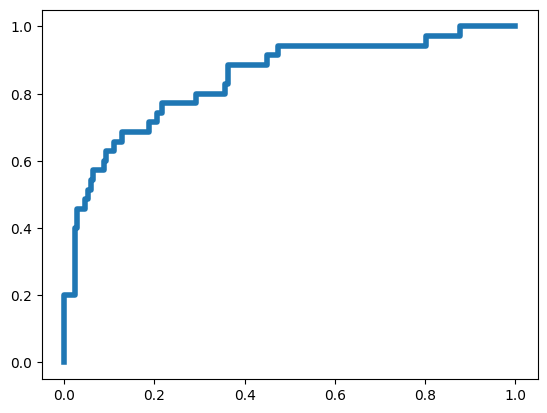

In [77]:
# Evaluate
print('roc_auc:', np.round(roc_auc_score(y_test, y_pred_test_prob), 3))
print('accuracy:', np.round(accuracy_score(y_test, y_pred_test), 3))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob)
plt.plot(fpr, tpr, linewidth=4)
plt.show()

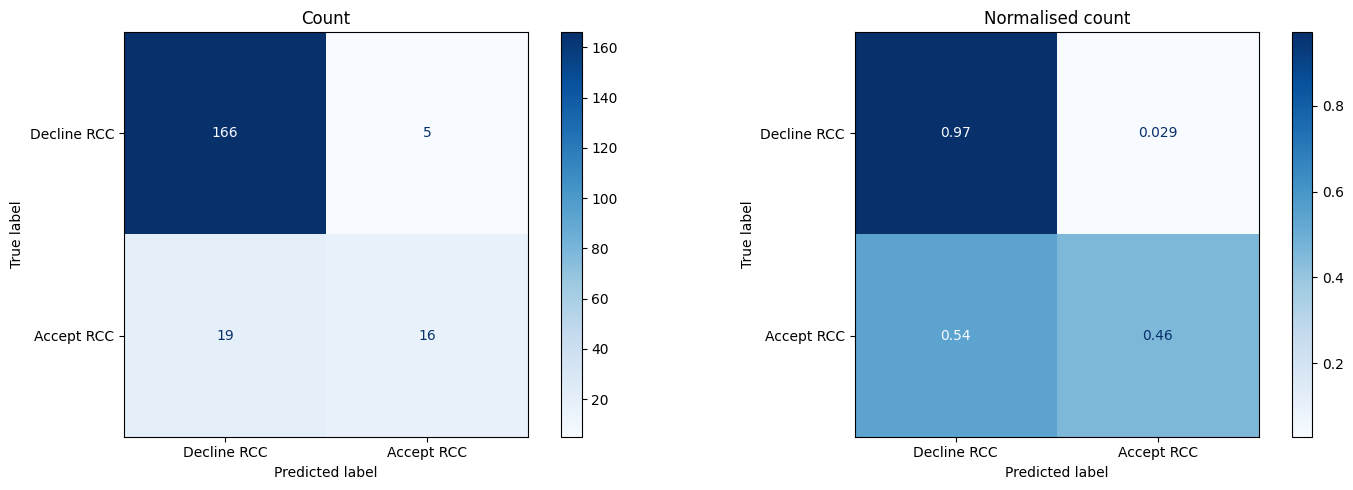

In [78]:
# Confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.from_predictions(y_test, y_pred_test, normalize=None, ax=axs[0], display_labels=['Decline RCC', 'Accept RCC'], cmap='Blues')
axs[0].set_title('Count')
disp.from_predictions(y_test, y_pred_test, normalize='true', ax=axs[1], display_labels=['Decline RCC', 'Accept RCC'], cmap='Blues')
axs[1].set_title('Normalised count')
plt.tight_layout()
plt.show()

In [79]:
# Final model - Trained with the whole dataset
X_final = pd.concat([X_train, X_test], ignore_index=True)
y_final = pd.concat([y_train, y_test], ignore_index=True)

final_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    **clf.best_params_
).fit(X_final, y_final)
# endregion

In [80]:
# region predict RCC
to_predict = pd.read_csv('./data/employee_attrition_lyon.csv')

X_to_predict = preprocess(to_predict, encoder, scaler, imputer, to_drop_cols)
X_to_predict = X_to_predict.drop(high_vif_cols, axis=1)
to_predict['RCC_acceptance'] = final_model.predict_proba(X_to_predict)[:, 1]

to_predict.to_csv('./output/lyon_acceptance.csv', index=False)
# endregion